In [72]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

from PIL import Image

from skimage.feature import hog
from skimage.color import rgb2grey

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc

In [74]:
#-----------------------------------
# GLOBAL FEATURE EXTRACTION
#-----------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py

#--------------------
# tunable-parameters
#--------------------
images_per_class = 1000
fixed_size       = tuple((342, 256))
train_path       = "dataset/train"
h5_data          = '/home/zxt/code/flower/output/data.h5'
h5_labels        = '/home/zxt/code/flower/output/labels.h5'
bins             = 8

In [75]:
df = pd.read_csv('/home/zxt/code/flower/df_all_1000.csv',index_col=0)

In [76]:
df.head(2)

,image_id,label
221064,591364e8-23d2-11e8-a6a3-ec086b02610b.jpg,racoon
216900,59408513-23d2-11e8-a6a3-ec086b02610b.jpg,racoon


In [77]:
# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

In [78]:
img_path = '/home/zxt/data/all/resized_data/'

In [79]:
imglist = list(df['image_id'])

In [80]:
global_features = []
labels =list(df['label'])
count = 0

for i in imglist:
    dir = img_path+i
    image =cv2.imread(dir)
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image) 
    fv_histogram  = fd_histogram(image)
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
    global_features.append(global_feature)
    count +=1
    if count % 1000 ==0:
        print(count)                          

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000


In [81]:
# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))

# encode the target labels
targetNames = np.unique(labels)
le          = LabelEncoder()
target      = le.fit_transform(labels)
print("[STATUS] training labels encoded...")

# scale features in the range (0-1)
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

# save the feature vector using HDF5
h5f_data = h5py.File(h5_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File(h5_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

print("[STATUS] end of training..")

[STATUS] feature vector size (21000, 532)
[STATUS] training Labels (21000,)
[STATUS] training labels encoded...
[STATUS] feature vector normalized...
[STATUS] target labels: [14 14 14 ...  1  1  1]
[STATUS] target labels shape: (21000,)
[STATUS] end of training..


In [82]:
#-----------------------------------
# TRAINING OUR MODEL
#-----------------------------------
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib

warnings.filterwarnings('ignore')

#--------------------
# tunable-parameters
#--------------------
num_trees = 100
test_size = 0.10
seed      = 9
train_path = "dataset/train"
test_path  = "dataset/test"
h5_data    = 'output/data.h5'
h5_labels  = 'output/labels.h5'
scoring    = "accuracy"

# get the training labels
train_labels = ['elephant','wild_boar','gazellethomosons','squirrel','hedgehog','guineafowl','moose','coyote','bird',
                  'fox','giraffe','buffalo','hare','vehicle','wildebeest','cattle','skunk','lion','zebra','black_bear',
                  'racoon']
# sort the training labels
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
# models.append(('SVM', SVC(random_state=seed)))

# variables to hold the results and names
results = []
names   = []

# import the feature vector and trained labels
h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")

[STATUS] features shape: (21000, 532)
[STATUS] labels shape: (21000,)
[STATUS] training started...


In [83]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))

[STATUS] splitted train and test data...
Train data  : (18900, 532)
Test data   : (2100, 532)
Train labels: (18900,)
Test labels : (2100,)


LR: 0.425714 (0.006723)
LDA: 0.409524 (0.007755)
KNN: 0.532963 (0.014779)
CART: 0.495132 (0.012067)
RF: 0.664656 (0.013358)
NB: 0.289788 (0.008532)


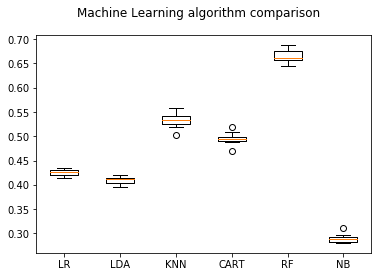

In [84]:
# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [25]:
test_img = os.listdir('/home/zxt/data/all/sample_20')

In [36]:
lst =[]
for i in test_img:
    if i[-3:]=='jpg':
        print(i)
        lst.append(i)

bobcat_FL-08_01_21_2016_FL-08_0015297.jpg
moose_2016_Unit178_Ivan027_img2024.jpg
bobcat_5987b545-23d2-11e8-a6a3-ec086b02610b.jpg
wildboar_.jpg
wildboarCA-44_09_11_2015_CA-44_0007006.jpg
moose_2010_Unit178_Ivan028_img0728.jpg
squirrel_59b12fb6-23d2-11e8-a6a3-ec086b02610b.jpg
squirrel_596bdac5-23d2-11e8-a6a3-ec086b02610b.jpg
bird_58aa59ce-23d2-11e8-a6a3-ec086b02610b.jpg
fox_2015_Unit020_Ivan129_img0327.jpg
moose_2015_Unit097_Ivan073_img0252.jpg
fox_58ef6ea0-23d2-11e8-a6a3-ec086b02610b.jpg


In [37]:
# lst = ['fox_58ef6ea0-23d2-11e8-a6a3-ec086b02610b.jpg']

0


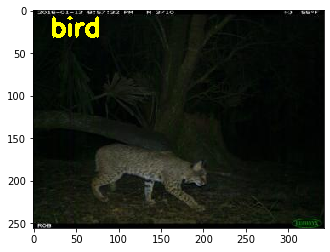

0


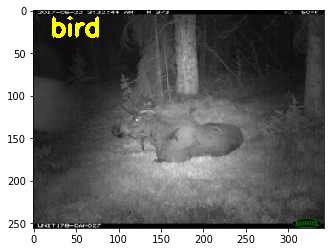

0


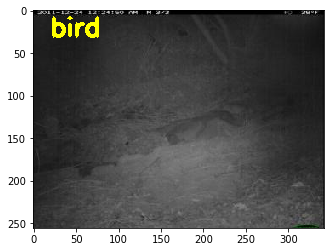

17


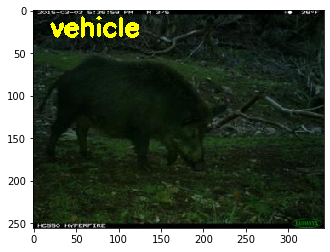

0


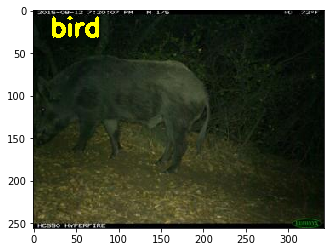

4


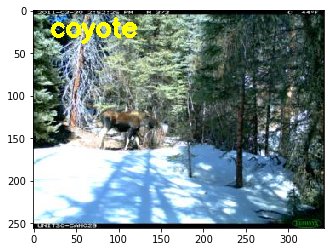

4


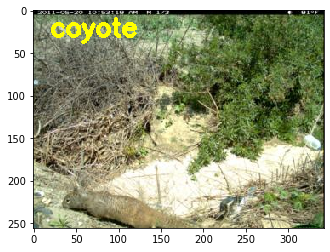

4


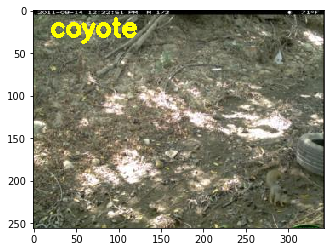

4


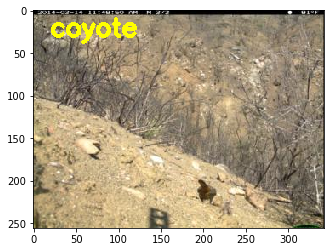

0


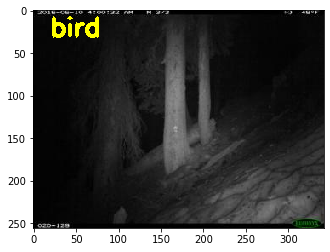

11


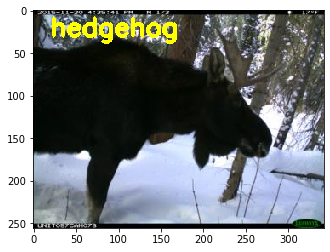

0


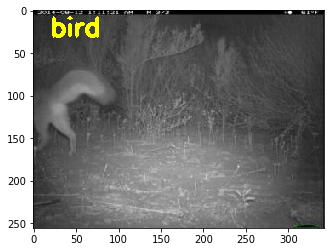

In [85]:
#-----------------------------------
# TESTING OUR MODEL
#-----------------------------------

# to visualize results
import matplotlib.pyplot as plt

# create the model - Random Forests
clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)

# loop through the test images
for file in lst:
    dir = '/home/zxt/data/all/sample_20/'+file
#     # read the image
    image = cv2.imread(dir)

    # resize the image
#     image = cv2.resize(image, fixed_size)

    ####################################
    # Global Feature extraction
    ####################################
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)

    ###################################
    # Concatenate global features
#     ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

#     # scale features in the range (0-1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    rescaled_feature = scaler.fit_transform(global_feature.reshape(-1,1))

#     # predict label of test image
    prediction = clf.predict(rescaled_feature.reshape(1,-1))[0]

    # show predicted label on image
#     cv2.putText(image, train_labels[prediction])
    cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)
    print(prediction)
    # display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

In [53]:
train_labels

[]